In [ ]:
!pip install numpy scipy torchvision transformers datasets scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [41]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer


In [42]:
import os

# Make sure you've mounted your Google Drive first:
from google.colab import drive
drive.mount('/content/drive')

# Define the folder path (adjust this to your folder location)
folder_path = '/content/drive/My Drive/datasets/thermal'

# Check if the folder exists
if os.path.isdir(folder_path):
    print(f"Folder exists at: {folder_path}")
else:
    print("Folder does not exist.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder exists at: /content/drive/My Drive/datasets/thermal


In [43]:
# 1. Define different facial expression labels
expression_labels = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

In [44]:
# 2. Load image file paths and labels
def load_thermal_dataset(dataset_path):
    image_paths = []
    labels = []
    for expression, label in expression_labels.items():
        folder_path = os.path.join(dataset_path, expression)
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg','.bmp')):
                    image_paths.append(os.path.join(folder_path, img_file))
                    labels.append(label)
        else:
            print(f"Warning: Folder not found - {folder_path}")
    return image_paths, labels

# CHANGE THIS to your actual dataset path
dataset_path = '/content/drive/MyDrive/datasets/thermal'
image_paths, labels = load_thermal_dataset(dataset_path)
print(f"Loaded {len(image_paths)} images.")

Loaded 7 images.


In [49]:
# 3. and Dataset Class
train_transforms = transforms.Compose([
    # flip left-right
    transforms.RandomHorizontalFlip(),
     # small rotation
    transforms.RandomRotation(degrees=15),
     # slight zoom crop
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
     # convert to tensor (important for feature extractor)
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class ThermalDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L').convert('RGB')
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoding['pixel_values'].squeeze()
        label = self.labels[idx]
        return {"pixel_values": pixel_values, "label": label}


In [50]:
#4. Train/Val Split
#  Use an 80-20 split (80% training, 20% validation)
#  Set random_state=42 for reproducibility of the split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)


#5. Initialize the Hugging Face ViT feature extractor and model
#  Specify the pretrained ViT model name (ViT base with 16x16 patches trained on ImageNet21k)
#  Load the feature extractor for preprocessing images (resizing, normalization, etc.)
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)



# Create PyTorch datasets for training and validation using the ThermalDataset class,
#  which applies the feature extractor to each image and returns pixel values and labels
train_dataset = ThermalDataset(train_paths, train_labels, feature_extractor)
val_dataset = ThermalDataset(val_paths, val_labels, feature_extractor)



# Load the pretrained ViT model for image classification,
#  setting the number of output classes equal to the number of emotion categories
#  ignore_mismatched_sizes=True allows loading the pretrained weights even if classifier head size differs
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(expression_labels),
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# 6 Define compute metrics function for Hugging Face Trainer
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [52]:
import transformers
print(transformers.__version__)


4.52.4


In [53]:
from transformers import Trainer, TrainingArguments

# 7. Define training arguments
# - output_dir: directory to save checkpoints and logs
# - per_device_train_batch_size: batch size per GPU/CPU for training
# - per_device_eval_batch_size: batch size per GPU/CPU for evaluation
# - num_train_epochs: number of training epochs
# - logging_dir: directory to save logs for TensorBoard
# - logging_steps: how often to log training info (every 50 steps)
training_args = TrainingArguments(
    output_dir="./vit-thermal-fer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=50
)

# 8. Initialize the Trainer with model, training args, datasets, and metric computation function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 9. Start model training using the configured Trainer
trainer.train()


Step,Training Loss


TrainOutput(global_step=5, training_loss=1.640828514099121, metrics={'train_runtime': 88.1149, 'train_samples_per_second': 0.284, 'train_steps_per_second': 0.057, 'total_flos': 1937386557388800.0, 'train_loss': 1.640828514099121, 'epoch': 5.0})

In [29]:
# 10. Get predictions on validation set for detailed evaluation

# Create DataLoader for the validation dataset with batch size 32, no shuffling
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set model to evaluation mode (disables dropout, etc.)
model.eval()

# Detect device (GPU if available, else CPU) and move model there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Lists to store all predictions and true labels
all_preds = []
all_labels = []


# Disable gradient calculation for faster inference and less memory use
with torch.no_grad():
    for batch in val_loader:
        # Access 'pixel_values' and 'label' from the batch dict
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        # Forward pass through the model
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Get predicted class indices
        preds = torch.argmax(logits, dim=1)

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#10.  Performance evaluation and confusion matrix

# Overall classification metrics
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Find unique classes in the labels
unique_labels = np.unique(all_labels)

# Get matching emotion names only for classes present
emotion_names = [expr.capitalize() for expr, idx in expression_labels.items() if idx in unique_labels]

print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=unique_labels,        # Must specify labels to match target_names
    target_names=emotion_names,
    zero_division=0
))



Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       1.0
     Disgust       0.00      0.00      0.00       1.0

   micro avg       0.00      0.00      0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



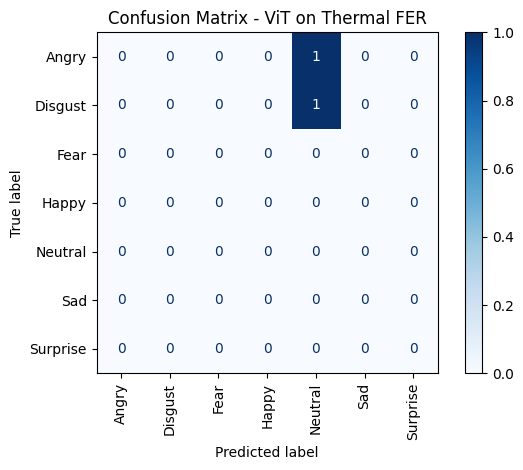

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# List of all class indices and display labels
all_classes = list(expression_labels.values())           # [0, 1, 2, 3, 4, 5, 6]
display_labels = [label.capitalize() for label in expression_labels.keys()]

# Plot confusion matrix with all 7 classes forced
disp = ConfusionMatrixDisplay.from_predictions(
    all_labels,
    all_preds,
    labels=all_classes,              # force confusion matrix for all classes
    display_labels=display_labels,  # class names shown on axes
    cmap=plt.cm.Blues,
    xticks_rotation='vertical'
)

plt.title("Confusion Matrix - ViT on Thermal FER")
plt.tight_layout()
plt.show()

# Instructions to run on Google Colab:
- Go to your google drive
- Create a folder named datasets/thermal
- Inside thermal folder, create 7 separate folders — each named after a different facial expression (e.g., angry, happy, sad, etc.)
- Put the images for each expression into the matching folder
- Name images like angry_1.jpg, happy_1.jpg, and so on
- Make sure to mount your Google Drive and set the dataset path accordingly before running the code